In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import os, re
import cv2
import glob
import pathlib
import time
import datetime
from IPython import display
from PIL import Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 1. Project_CutMix_vs_Mixup

## (1) Augmentation을 적용한 데이터셋 만들기

### 1) 데이터 불러오기

In [2]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], as_supervised=True, shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


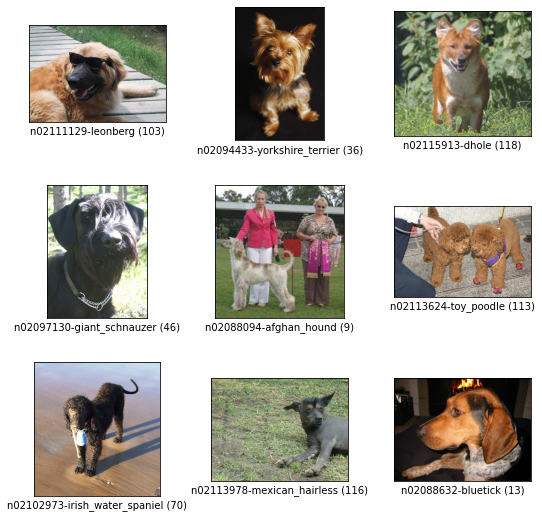

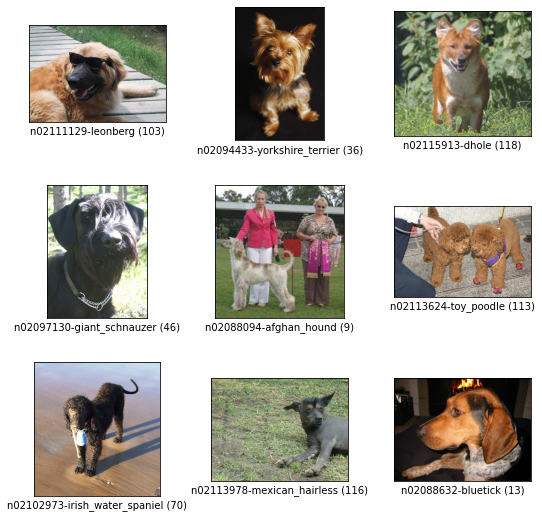

In [3]:
tfds.show_examples(ds_train, ds_info)

In [4]:
num_classes = ds_info.features["label"].num_classes

### 2) Cutmix Augmentation

#### - (1) 이미지 섞기

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max


# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

#### - (2) 라벨 섞기

In [6]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = 224
    image_size_y = 224
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label


def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 3) Mixup Augmentation

In [7]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label


def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 4) 데이터 전처리

In [8]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=True):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
        )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )     
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds

In [9]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

## (2) 모델 만들기

비교 실험을 위한 모델 네 개 만들기

In [10]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

94781440/94765736 [==============================] - 0s 0us/step


In [11]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [12]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [13]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

## (3) 모델 훈련하기

categorical_crossentropy( )를 사용할 것

In [14]:
EPOCH = 20

### 1) No Augmentation

In [15]:
resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,   # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 204s 203ms/step - loss: 3.6941 - accuracy: 0.2488 - val_loss: 4.0066 - val_accuracy: 0.1313
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.8450 - accuracy: 0.4776 - val_loss: 1.8510 - val_accuracy: 0.4973
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.5704 - accuracy: 0.5891 - val_loss: 1.4264 - val_accuracy: 0.6097
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.3740 - accuracy: 0.6600 - val_loss: 1.3658 - val_accuracy: 0.6194
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.2597 - accuracy: 0.7019 - val_loss: 1.1919 - val_accuracy: 0.6690
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1439 - accuracy: 0.7432 - val_loss: 1.1594 - val_accuracy: 0.6737
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.0734 - accuracy: 0.7736 - val_loss: 1.4546 -

### 2) 기본 Augmentation

In [16]:
aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,      # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 161s 205ms/step - loss: 3.7798 - accuracy: 0.2224 - val_loss: 3.5171 - val_accuracy: 0.1807
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.9364 - accuracy: 0.4417 - val_loss: 1.6691 - val_accuracy: 0.5427
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 2.6738 - accuracy: 0.5458 - val_loss: 1.6406 - val_accuracy: 0.5598
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 2.5150 - accuracy: 0.6041 - val_loss: 1.2885 - val_accuracy: 0.6421
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 2.3916 - accuracy: 0.6524 - val_loss: 1.4327 - val_accuracy: 0.6111
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 2.3000 - accuracy: 0.6845 - val_loss: 1.2448 - val_accuracy: 0.6540
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 2.2285 - accuracy: 0.7143 - val_loss: 1.6487 -

### 3) 기본 + CutMix 적용

In [17]:
cutmix_aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_cutmix_aug = cutmix_aug_resnet50.fit(
    ds_train_cutmix_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 158s 204ms/step - loss: 2.1769 - accuracy: 0.6644 - val_loss: 1.2457 - val_accuracy: 0.6845
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 2.1031 - accuracy: 0.6844 - val_loss: 1.3498 - val_accuracy: 0.6620
Epoch 3/20
750/750 [==============================] - 168s 224ms/step - loss: 2.0219 - accuracy: 0.7138 - val_loss: 1.4129 - val_accuracy: 0.6442
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 1.9749 - accuracy: 0.7265 - val_loss: 1.3013 - val_accuracy: 0.6744
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 1.9437 - accuracy: 0.7298 - val_loss: 1.2179 - val_accuracy: 0.6955
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 1.8783 - accuracy: 0.7459 - val_loss: 1.2599 - val_accuracy: 0.6913
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 1.8394 - accuracy: 0.7611 - val_loss: 1.4141 -

### 4) 기본 + Mixup 적용

In [18]:
mixup_aug_resnet50.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet50_mixup_aug = mixup_aug_resnet50.fit(
    ds_train_mixup_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/20
750/750 [==============================] - 159s 206ms/step - loss: 1.7211 - accuracy: 0.8627 - val_loss: 1.4397 - val_accuracy: 0.6680
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 1.7110 - accuracy: 0.8648 - val_loss: 1.4689 - val_accuracy: 0.6763
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 1.6907 - accuracy: 0.8662 - val_loss: 1.4340 - val_accuracy: 0.6758
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 1.6701 - accuracy: 0.8622 - val_loss: 1.3825 - val_accuracy: 0.6830
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 1.6608 - accuracy: 0.8692 - val_loss: 1.4800 - val_accuracy: 0.6586
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 1.6575 - accuracy: 0.8651 - val_loss: 1.3954 - val_accuracy: 0.6827
Epoch 7/20
750/750 [==============================] - 154s 206ms/step - loss: 1.6283 - accuracy: 0.8689 - val_loss: 1.3450 -

## (4) 훈련 과정 시각화하기

### 1) 훈련 과정 시각화

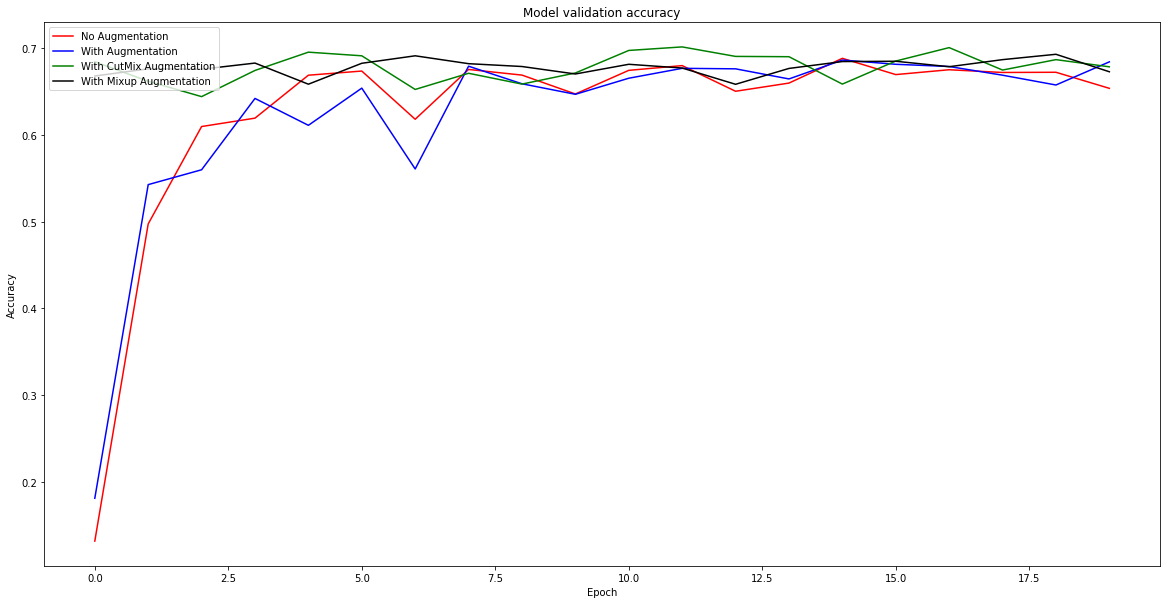

In [25]:
plt.figure(figsize = (20, 10))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix Augmentation', 'With Mixup Augmentation'], loc='upper left')
plt.show()

### 2) 훈련 과정 확대 시각화

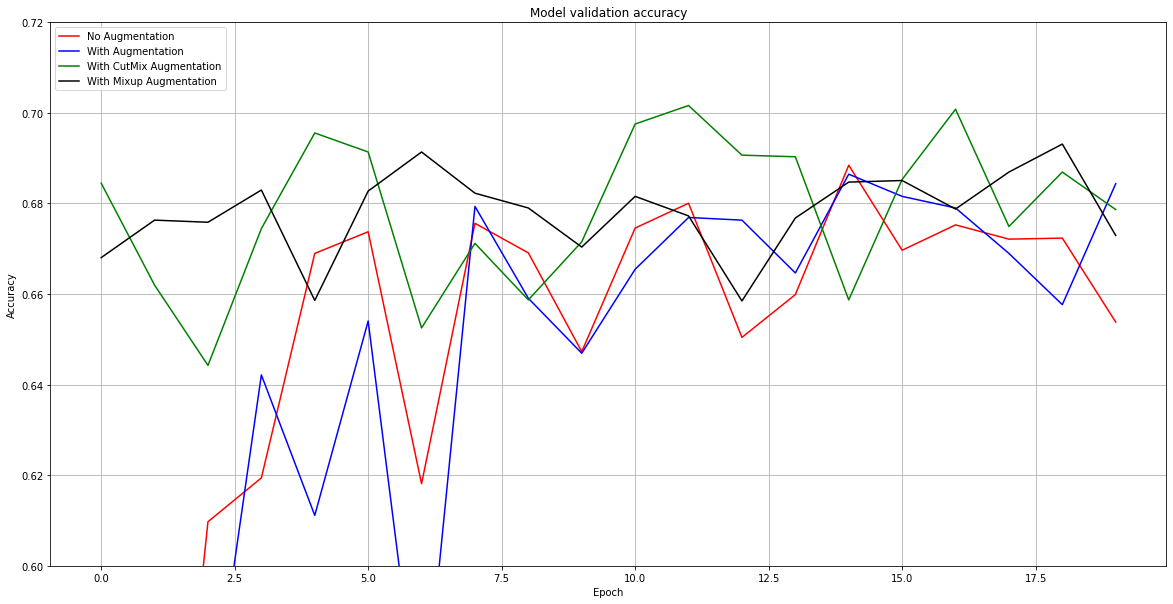

In [30]:
plt.figure(figsize = (20, 10))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup_aug.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix Augmentation', 'With Mixup Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.72)
plt.show()

# 2. Conclusion


### <4가지 기법을 사용한 결과 분석>

훈련 데이터 증강(Augmentation) 기법은 일반화 성능을 향상시키는 데 도움이 되며, 과적합을 방지하는 데 중요하다. Augmentation 기법을 사용하면 모델은 학습 중에 다양한 변형된 데이터를 볼 수 있기 때문에 일반화 능력이 향상된다.

하지만 초기에는 Augmentation을 사용한 경우 모델이 이전에 본 적이 없는 새로운 데이터를 보게 되기 때문에 Accuracy가 낮을 수 있다. 이는 Augmentation이 모델에 더 많은 변화를 제공하므로 초기에는 모델이 이에 대해 적응할 수 있는 충분한 학습이 필요하기 때문이다. 훈련 Epoch가 증가함에 따라 모델이 더 많은 데이터와 변형을 보기 때문에 Augmentation을 사용한 경우의 일반화 능력이 향상되어 Accuracy가 증가한다.

또한 CutMix와 Mixup 같은 더 복잡한 Augmentation 기법을 사용하면, 모델이 다양한 데이터 및 레이블 조합을 더 많이 볼 수 있으므로 일반화 능력이 더 향상될 수 있다. 따라서 CutMix 및 Mixup과 같은 기술을 사용할 때도 초기에는 Accuracy가 낮을 수 있지만, 훈련 Epoch가 증가함에 따라 성능이 향상된다.

따라서 Epoch가 증가함에 따라 모든 Augmentation 기술이 수렴하는 것은 일반화 능력이 향상되면서 모델이 더 잘 일반화되기 때문이다.

마지막으로 위의 실험을 통해 분석된 최적화된 방법은, Epoch의 수가 낮을 때는 Augmentation + CutMix를 사용한 경우, Augmentation + Mixup을 사용한 경우이고, Epoch의 수가 13이상인 경우에는 일반화 능력의 향상으로 인해 모든 기술의 Accuracy가 0.7 정도에 수렴해가므로 4가지 중 어떤 것을 사용해도 무방하다.



### <4가지 기법의 장단점>


#### 1. Augmentation을 사용하지 않은 경우

- 성능: 이미지 데이터가 부족한 경우 과적합 문제가 발생할 가능성이 높아지며, 모델의 일반화 성능이 떨어질 수 있다.

- 장점: 데이터 증강 기술을 적용하지 않아도 모델의 학습 및 추론이 빠르고 간단해진다.

#### 2. Augmentation을 사용한 경우

- 성능: 이미지 데이터 증강 기술을 적용하면 데이터의 다양성과 양을 증가시키므로 모델의 일반화 성능이 향상될 수 있다.

- 장점: 데이터의 다양성을 증가시켜 모델의 성능을 높일 수 있다.

#### 3. Augmentation + CutMix를 사용한 경우

CutMix는 이미지에서 임의로 선택한 영역을 다른 이미지로 대체하여 새로운 이미지를 생성하는 방식이다. CutMix를 적용하면 데이터의 라벨 정보도 섞이게 되므로 모델이 라벨 정보를 더 잘 학습할 수 있게 된다.

- 성능: CutMix를 사용하면 모델의 성능이 향상될 수 있습니다. 일부 데이터셋에서는 기존의 augmentation 기법보다 더 좋은 성능을 보이기도 한다.

- 장단점: CutMix를 적용하면 모델의 성능이 향상될 수 있지만, 이미지 내의 중요한 정보가 사라지는 문제가 발생할 수 있다.

#### 4. Augmentation + Mixup을 사용한 경우

Mixup은 이미지를 선형적으로 섞는 방식으로, 두 개의 이미지를 섞어 새로운 이미지를 생성한다. Mixup을 적용하면 데이터의 라벨 정보도 섞이게 되므로 모델이 라벨 정보를 더 잘 학습할 수 있게 된다.

- 성능: Mixup을 사용하면 모델의 성능이 향상될 수 있다. 일부 데이터셋에서는 기존의 augmentation 기법보다 더 좋은 성능을 보이기도 한다.

- 장단점: Mixup을 적용하면 모델의 성능이 향상될 수 있지만, 이미지 내의 중요한 정보가 사라지는 문제가 발생할 수 있다. 또한, Mixup은 픽셀 값이 선형적으로 섞이기 때문에 이미지 내의 각 요소들이 서로 다른 가중치를 가지는 것과 같은 형태의 데이터에는 적용하기 어려울 수 있다. 이러한 경우에는 CutMix나 다른 증강 기법을 적용하는 것이 더 적절할 수 있다.

# 3. References

[1] https://lms.aiffel.io/course/405/node/465